We will use the [Fuel](https://github.com/mila-udem/fuel) library to access datasets. Fuel is designed to provide easy iteration over large datasets, however in this assignment we will only use its ability to download and convert some standard datasets for us.

We will use the following datasets:
1. IRIS https://archive.ics.uci.edu/ml/datasets/Iris available as `fuel.datasets.iris.Iris`
2. MNIST http://yann.lecun.com/exdb/mnist/ available as `fuel.datasets.mnist.MNIST`
3. CIFAR10 http://www.cs.toronto.edu/~kriz/cifar.html available as `fuel.datasets.cifar10.CIFAR10`

On lab computers the datasets have already been downloaded for you into the `/pio/data/data/fuel` directory. Make sure to add it to the `FUEL_DATA_PATH` environment variable!

If you are working from your computer, you can either use the Fuel downloader and converter utulities (http://fuel.readthedocs.org/en/latest/built_in_datasets.html) or download the HDF5 datasets:

1. [Iris](https://drive.google.com/uc?export=download&id=0B5j9vIO_Njwcb2ItV2ZLakR6MEk)
2. [MNIST](https://drive.google.com/uc?export=download&id=0B5j9vIO_NjwcNnYzVTNIVGxaSEk)
3. [CIFAR10](https://drive.google.com/uc?export=download&id=0B5j9vIO_NjwcOEdlU2RtNkc2bW8)


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 1

In [2]:
from numpy import array

from fuel.datasets.mnist import MNIST
from fuel.datasets.cifar10 import CIFAR10
from common.plotting import plot_mat

We have 50000 training, 10000 validation, and 10000 test examples
The examples are pairs of (u'features', u'targets'):
The source #0 named "features" is a 4d array with axis: (u'batch', u'channel', u'height', u'width')
The source #1 named "targets" is a 2d array with axis: (u'batch', u'index')


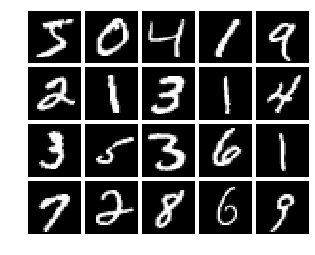

In [37]:
mnist_train = MNIST(("train",), subset=slice(None,50000))
mnist_validation = MNIST(("train",), subset=slice(50000, None))
mnist_test = MNIST(("test",))

print "We have %d training, %d validation, and %d test examples" % (
    mnist_train.num_examples, mnist_validation.num_examples, mnist_test.num_examples)
print "The examples are pairs of %s:" % (mnist_train.sources,)
for i, source in enumerate(mnist_train.sources):
    labels = mnist_train.axis_labels[source]
    print 'The source #%d named "%s" is a %dd array with axis: %s' % (
        i, source, len(labels), labels)

#Note that for larger datasets that are loaded into mameory the data_sources field may not exist!
plot_mat(mnist_train.data_sources[0][:20], cmap='gray')

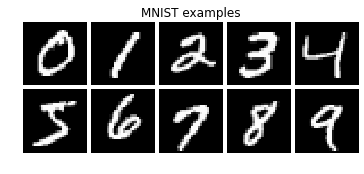

In [7]:
example_indexes, needed = [None]*10, range(10)
i = 0
while needed:
    number = mnist_train.data_sources[1][i][0]
    if number in needed:
        needed.remove(number)
        example_indexes[number] = i
    i += 1

plot_mat(mnist_train.data_sources[0][example_indexes], cmap='gray')
title("MNIST examples")

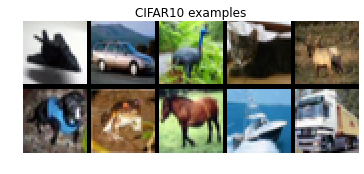

In [3]:
cifar_train = CIFAR10(("train",), subset=slice(None, 40000))
cifar_validation = CIFAR10(("train",), subset=slice(40000, None))
cifar_test = CIFAR10(("test",))

example_indexes, needed = [None]*10, range(10)
i = 0
while needed:
    cifar_cat = cifar_train.data_sources[1][i][0]
    if cifar_cat in needed:
        needed.remove(cifar_cat)
        example_indexes[cifar_cat] = i
    i += 1

plot_mat(cifar_train.data_sources[0][example_indexes], cmap='gray')
title("CIFAR10 examples")

In [38]:
#Extract the data matrices

mnist_train_X = (mnist_train.data_sources[0].reshape(mnist_train.num_examples, -1) / 255.0).astype(np.single)
mnist_train_Y = mnist_train.data_sources[1].ravel()

mnist_valid_X = (mnist_validation.data_sources[0].reshape(mnist_validation.num_examples, -1) / 255.0).astype(np.single)
mnist_valid_Y = mnist_validation.data_sources[1].ravel()

In [4]:
from scipy.stats import mode

def KNN(train_X, train_Y, test_X, test_Y, ks, batch_size=200):
    """
    Compute error rate for various 
    """
    errs = np.zeros((len(ks),))
    for i in xrange(0,test_Y.shape[0], batch_size):
        batch_X = test_X[i:i + batch_size]
        batch_Y = test_Y[i:i + batch_size]
        print "Examples %d:%d Computing distances... " %(i,i+batch_size), 
        
        dists = array([((train_X - test)**2).sum(axis=1) for test in batch_X])
        """
        dists = np.empty([batch_size, train_X.shape[0]], dtype=np.single)
        for j in range(batch_size):
            for k in range(train_X.shape[0]):
                dists[j][k] = ((train_X[k] - batch_X[j])**2).sum()
        """
        print "Sorting... ",
        closest = np.argsort(dists)

        print "Computing errors..."
        targets = train_Y[closest]
        
        for ki,k in enumerate(ks):
            predictions, unused_counts = mode(targets[:,:k], axis=1)
            predictions = predictions.ravel()
            errs[ki] += batch_size - np.sum(predictions==batch_Y)
        
    errs /= test_Y.shape
    return np.vstack((ks, errs))

Examples 0:200 Computing distances...  Sorting...  Computing errors...
Examples 200:400 Computing distances...  Sorting...  Computing errors...
Examples 400:600 Computing distances...  Sorting...  Computing errors...
Examples 600:800 Computing distances...  Sorting...  Computing errors...
Examples 800:1000 Computing distances...  Sorting...  Computing errors...
Examples 1000:1200 Computing distances...  Sorting...  Computing errors...
Examples 1200:1400 Computing distances...  Sorting...  Computing errors...
Examples 1400:1600 Computing distances...  Sorting...  Computing errors...
Examples 1600:1800 Computing distances...  Sorting...  Computing errors...
Examples 1800:2000 Computing distances...  Sorting...  Computing errors...
Examples 2000:2200 Computing distances...  Sorting...  Computing errors...
Examples 2200:2400 Computing distances...  Sorting...  Computing errors...
Examples 2400:2600 Computing distances...  Sorting...  Computing errors...
Examples 2600:2800 Computing distanc

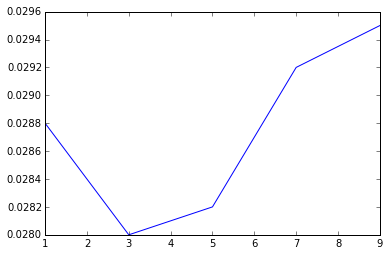

In [12]:
# Now find the best k on the validation set

mnist_validation_errs = KNN(mnist_train_X, mnist_train_Y, mnist_valid_X, mnist_valid_Y, [1,3,5,7,9])
plot(mnist_validation_errs[0,:], mnist_validation_errs[1,:])


In [19]:
# Now use the best k to compute the test error

best_K = mnist_validation_errs[0][np.argmin(mnist_validation_errs[1])]

mnist_full_train = MNIST(("train",), )

mnist_full_train_X = (mnist_full_train.data_sources[0].reshape(mnist_full_train.num_examples, -1) / 255.0).astype(np.single)
mnist_full_train_Y = mnist_full_train.data_sources[1].ravel()

mnist_test_X = (mnist_test.data_sources[0].reshape(mnist_test.num_examples, -1) / 255.0).astype(np.single)
mnist_test_Y = mnist_test.data_sources[1].ravel()

mnist_test_errs = KNN(mnist_full_train_X, mnist_full_train_Y, mnist_test_X, mnist_test_Y, [best_K])
print "When k=%d the test error rate is %.1f%%" % (mnist_test_errs[0,0], mnist_test_errs[1,0]*100.0)

Examples 0:200 Computing distances...  Sorting...  Computing errors...
Examples 200:400 Computing distances...  Sorting...  Computing errors...
Examples 400:600 Computing distances...  Sorting...  Computing errors...
Examples 600:800 Computing distances...  Sorting...  Computing errors...
Examples 800:1000 Computing distances...  Sorting...  Computing errors...
Examples 1000:1200 Computing distances...  Sorting...  Computing errors...
Examples 1200:1400 Computing distances...  Sorting...  Computing errors...
Examples 1400:1600 Computing distances...  Sorting...  Computing errors...
Examples 1600:1800 Computing distances...  Sorting...  Computing errors...
Examples 1800:2000 Computing distances...  Sorting...  Computing errors...
Examples 2000:2200 Computing distances...  Sorting...  Computing errors...
Examples 2200:2400 Computing distances...  Sorting...  Computing errors...
Examples 2400:2600 Computing distances...  Sorting...  Computing errors...
Examples 2600:2800 Computing distanc

/home/bartosz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
cifar_train_X = (cifar_train.data_sources[0].reshape(cifar_train.num_examples, -1) / 255.0).astype(np.single)
cifar_train_Y = cifar_train.data_sources[1].ravel()

cifar_valid_X = (cifar_validation.data_sources[0].reshape(cifar_validation.num_examples, -1) / 255.0).astype(np.single)
cifar_valid_Y = cifar_validation.data_sources[1].ravel()

Examples 0:200 Computing distances...  Sorting...  Computing errors...
Examples 200:400 Computing distances...  Sorting...  Computing errors...
Examples 400:600 Computing distances...  Sorting...  Computing errors...
Examples 600:800 Computing distances...  Sorting...  Computing errors...
Examples 800:1000 Computing distances...  Sorting...  Computing errors...
Examples 1000:1200 Computing distances...  Sorting...  Computing errors...
Examples 1200:1400 Computing distances...  Sorting...  Computing errors...
Examples 1400:1600 Computing distances...  Sorting...  Computing errors...
Examples 1600:1800 Computing distances...  Sorting...  Computing errors...
Examples 1800:2000 Computing distances...  Sorting...  Computing errors...
Examples 2000:2200 Computing distances...  Sorting...  Computing errors...
Examples 2200:2400 Computing distances...  Sorting...  Computing errors...
Examples 2400:2600 Computing distances...  Sorting...  Computing errors...
Examples 2600:2800 Computing distanc

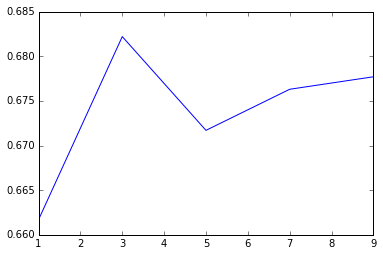

In [6]:
cifar_validation_errs = KNN(cifar_train_X, cifar_train_Y, cifar_valid_X, cifar_valid_Y, [1,3,5,7,9])

plot(cifar_validation_errs[0,:], cifar_validation_errs[1,:])

In [5]:
best_K = cifar_validation_errs[0][np.argmin(cifar_validation_errs[1])]

cifar_full_train = CIFAR10(("train",), )
cifar_full_train_X = (cifar_full_train.data_sources[0].reshape(cifar_full_train.num_examples, -1) / 255.0).astype(np.single)
cifar_full_train_Y = cifar_full_train.data_sources[1].ravel()

cifar_test = CIFAR10(("test",), )
cifar_test_X = (cifar_test.data_sources[0].reshape(cifar_test.num_examples, -1) / 255.0).astype(np.single)
cifar_test_Y = cifar_test.data_sources[1].ravel()

cifar_test_errs = KNN(cifar_full_train_X, cifar_full_train_Y, cifar_test_X, cifar_test_Y, [best_K])
print "When k=%d the test error rate is %.1f%%" % (cifar_test_errs[0,0], cifar_test_errs[1,0]*100.0)

Examples 0:200 Computing distances...  Sorting...  Computing errors...
Examples 200:400 Computing distances...  Sorting...  Computing errors...
Examples 400:600 Computing distances...  Sorting...  Computing errors...
Examples 600:800 Computing distances...  Sorting...  Computing errors...
Examples 800:1000 Computing distances...  Sorting...  Computing errors...
Examples 1000:1200 Computing distances...  Sorting...  Computing errors...
Examples 1200:1400 Computing distances...  Sorting...  Computing errors...
Examples 1400:1600 Computing distances...  Sorting...  Computing errors...
Examples 1600:1800 Computing distances...  Sorting...  Computing errors...
Examples 1800:2000 Computing distances...  Sorting...  Computing errors...
Examples 2000:2200 Computing distances...  Sorting...  Computing errors...
Examples 2200:2400 Computing distances...  Sorting...  Computing errors...
Examples 2400:2600 Computing distances...  Sorting...  Computing errors...
Examples 2600:2800 Computing distanc

# Problem 2

In [6]:
def f(x):
    return 1 + 20*x - 1.3*x**2

def generator(n):
    x = np.random.uniform(0, 10, n)
    y = np.random.normal(f(x), 7, n)
    return np.array([x, y]).T

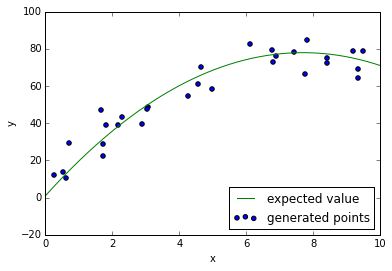

In [7]:
points = generator(30)
ran = np.linspace(0, 10, 1000)
scatter(points[:, 0], points[:, 1], label="generated points")
plot(ran, f(ran), color="g", label="expected value")
xlim(0, 10)
xlabel("x")
ylabel("y")
legend(loc="lower right")

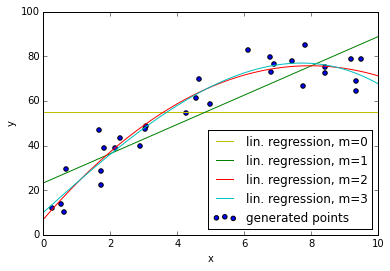

In [64]:
Y = points[:, 1]
for m in range(4):
    X = np.array([points[:, 0]**k for k in range(m + 1)])
    Theta = np.linalg.inv(X.dot(X.T)).dot(X).dot(Y.T)
    plot(ran, np.vectorize(lambda x: sum([Theta[i]*(x**i) for i in range(m + 1)]))(ran), color="ygrc"[m], label="lin. regression, m=%d" % m)

scatter(points[:, 0], points[:, 1], label="generated points")
xlim(0, 10)
xlabel("x")
ylabel("y")
legend(loc="lower right")

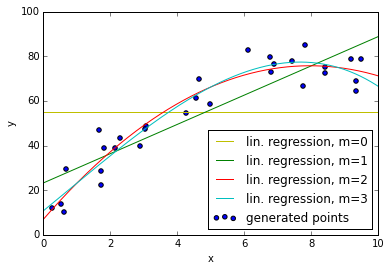

In [191]:
Y = np.array([points[:, 1]])
alphas = [1e-2, 1e-4, 1e-5, 1e-7]
for m in range(4):
    X = np.array([points[:, 0]**k for k in range(m + 1)])
    
    def J_gradient(Theta):
        E = Y - (Theta.T).dot(X)
        value = E.dot(E.T)
        gradient = -2*(X.dot(Y.T)) + 2*(X.dot(X.T).dot(Theta))
        return (value, gradient)
    
    Theta_0 = np.ones((m + 1, 1))
    Theta_min, history = GD(J_gradient, Theta_0, alphas[m])
    plot(ran, np.vectorize(lambda x: sum([Theta_min[i]*(x**i) for i in range(m + 1)]))(ran), color="ygrc"[m], label="lin. regression, m=%d" % m)

scatter(points[:, 0], points[:, 1], label="generated points")
xlim(0, 10)
xlabel("x")
ylabel("y")
legend(loc="lower right")

# Problem 3

In [2]:
from common.gradients import check_gradient,numerical_gradient

In [3]:
# A sample function for debugging purposes

def quadratic(X):
    value = X[0]**2 + 2*X[1]**2
    grad = np.array([2*X[0], 4*X[1]])
    return (value, grad)


# Let's check if the gradientis correctly computed
check_gradient(quadratic, np.array([0,0]))
check_gradient(quadratic, np.array([1.0,1.0]))

# Oh noes! We have an error in gradient computation - please correct it!

True

In [4]:
#
# Fill in the details of the gradient computation
#

def GD(f, Theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    history = [Theta0]
    
    Theta = Theta0
    value = np.inf
    
    step = 0
    while step<max_steps:
        previous_value = value
        value, gradient = f(Theta)
        
        if np.absolute(value - previous_value) < stop_tolerance:
            break
        
        Theta = Theta - alpha*gradient
        history.append(Theta)
        step += 1
    return Theta, history

In [5]:
#
# Test the GD procedure on the quadratic function
#

Xopt, Xhist = GD(quadratic, np.array((1,1)), 1e-1)
print "Found optimum at %s in %d steps (true minimum is at [0,0])" % (Xopt, len(Xhist))

Found optimum at [  1.14179815e-05   4.84968766e-12] in 52 steps (true minimum is at [0,0])


Found optimum at [ 0.99888301  0.9977628 ] in 139346 steps (true minimum is at [1,1])


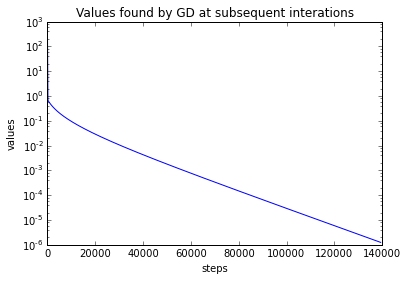

In [42]:
#
# Now implement the Rosenbrock function 
#

def rosenbrock(x, a = 1, b = 100):
    val = (a - x[0])**2 + b*(x[1] - x[0]**2)**2
    grad_x = -2*(a - x[0]) + 4*b*x[0]*(x[0]**2 - x[1])
    grad_y = 2*b*(x[1] - x[0]**2)
    grad = np.array((grad_x, grad_y))
    return val, grad

#
# And test its gradient
#
check_gradient(rosenbrock, np.array([0.,0.]), delta=1e-8)
check_gradient(rosenbrock, np.array([1.0,1.0]), delta=1e-8)

#
# Find the optimum
#

X0= (0.,2.)
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-4, stop_tolerance=1e-10)
Xhist = np.array(Xhist)

print "Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist))

ran = np.linspace(0, len(Xhist), len(Xhist))
plot(ran, [rosenbrock(x)[0] for x in Xhist])
xlabel("steps")
ylabel("values")
yscale('log')
title("Values found by GD at subsequent interations")

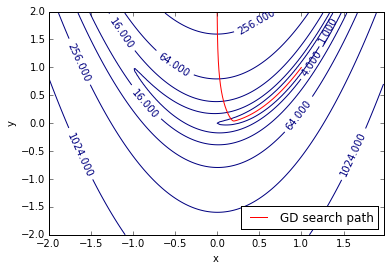

In [26]:
delta = 0.025
x = np.arange(-2, 2, delta)
y = np.arange(-2, 2, delta)
X, Y = np.meshgrid(x, y)
Z = numpy.array([rosenbrock(z)[0] for z in zip(X, Y)])
C = contour(X, Y, Z, [pow(4, x) for x in range(30)])
clabel(C)

plot(Xhist[:, 0], Xhist[:, 1], color='r', label="GD search path")
xlabel("x")
ylabel("y")
legend(loc="lower right")

Found optimum at [ 0.9999989  0.9999978] in 22 steps (true minimum is at [1,1])


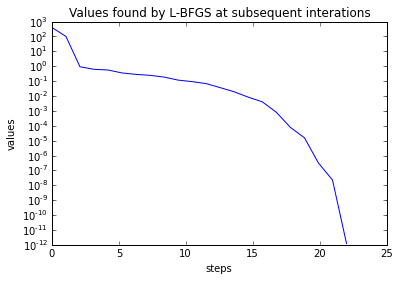

In [65]:
from scipy.optimize import fmin_l_bfgs_b

Xhist = [(0., 2.)]
Xopt, Yopt, d = fmin_l_bfgs_b(rosenbrock, X0, callback=lambda x: Xhist.append(x.copy()))
Xhist = np.array(Xhist)

print "Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist))

ran = np.linspace(0, len(Xhist), len(Xhist))
plot(ran, [rosenbrock(x)[0] for x in Xhist])
xlabel("steps")
ylabel("values")
yscale('log')
title("Values found by L-BFGS at subsequent interations")

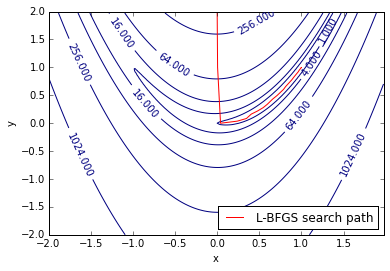

In [66]:
delta = 0.025
x = np.arange(-2, 2, delta)
y = np.arange(-2, 2, delta)
X, Y = np.meshgrid(x, y)
Z = np.array([rosenbrock(z)[0] for z in zip(X, Y)])
C = contour(X, Y, Z, [pow(4, x) for x in range(30)])
clabel(C)

plot(Xhist[:, 0], Xhist[:, 1], color='r', label="L-BFGS search path")
xlabel("x")
ylabel("y")
legend(loc="lower right")

# Problem 4

In [43]:
from sklearn import datasets
iris = datasets.load_iris()
print 'Features: ', iris.feature_names
print 'Targets: ', iris.target_names
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


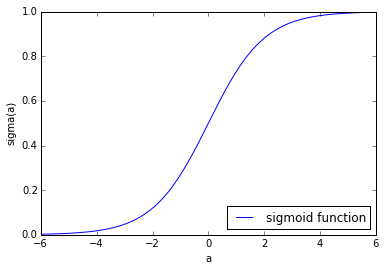

In [50]:
def sigma(a):
    return 1.0 / (1 + numpy.exp(-a))

ran = np.linspace(-6, 6, 1000)
plot(ran, sigma(ran), label="sigmoid function")
xlabel("a")
ylabel("sigma(a)")
legend(loc="lower right")

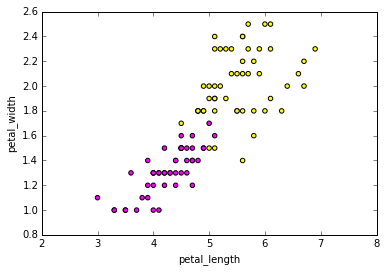

In [51]:
#Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')

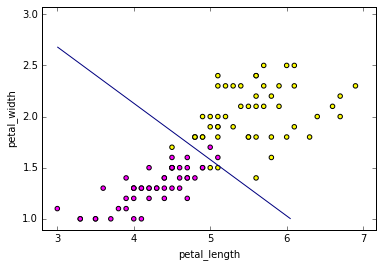

In [83]:
class LogisticRegressionCost(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    #note: this creates a Pyton callable - i.e. an abject that can be called as a function
    def __call__(self, Theta):
        X = self.X
        Y = self.Y
        
        #reshape Theta
        ThetaR = Theta.reshape(X.shape[0],1)
        
        #
        # Fill in negative log likelihood computation
        # and gradient computation
        #
        # Properly implemented, this takes about 3 lines of code!
        #
        
        hTheta = sigma(Theta.T.dot(X))
        
        nll = -numpy.sum(Y * numpy.log(hTheta) + (1 - Y) * numpy.log(1 - hTheta))
        
        grad = X.dot((hTheta - Y).T)
        
        #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
        return nll, grad.reshape(Theta.shape)

iris_log_reg = LogisticRegressionCost(IrisX, IrisY)

Theta0 = np.zeros((3))
check_gradient(iris_log_reg, Theta0)


#
# Call a solver
#

ThetaOpt = fmin_l_bfgs_b(iris_log_reg, Theta0)[0]

check_gradient(iris_log_reg, ThetaOpt)

scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')

delta = 0.025
x = np.arange(3.0, 7.0, delta)
y = np.arange(1.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z = np.array([sigma(ThetaOpt[0] + ThetaOpt[1]*x + ThetaOpt[2]*y) for x, y in zip(X, Y)])
contour(X, Y, Z, [.5])

xlabel('petal_length')
ylabel('petal_width')